In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
np.random.seed(42)

In [2]:
charset = {
                'digit_0' : 0,
                'digit_1' : 1,
                'digit_2' : 2,
                'digit_3' : 3,
                'digit_4' : 4,
                'digit_5' : 5,
                'digit_6' : 6,
                'digit_7' : 7,
                'digit_8' : 8,
                'digit_9' : 9,
}
train_data = pd.read_csv('./dataset/digit_all_augmented.csv')
test_data  = pd.read_csv('./dataset/test_digits_data.csv')
X_train = train_data.iloc[:, 1:-1].values
y_train = train_data.iloc[:, -1]
y_train = y_train.replace(charset)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .2)

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mm = StandardScaler()
X_train = mm.fit_transform(X_train)
# X_dev   = mm.fit_transform(X_dev)
X_test = mm.transform(X_test)

In [4]:
pickle.dump(mm,open('scaler_norm.pkl', 'wb') )

In [5]:
print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_data.shape)+"\t\t"+ str(X_train.shape))
print("Training Set Labels:\t" + str(train_data.iloc[:, -1].shape)+"\t\t"+ str(y_train.shape))
# print("Dev Set Images:\t\t" + str(X_dev.shape)+"\t\t"+ str(X_dev.shape))
# print("Dev Set Labels:\t\t" + str(y_dev.shape)+"\t\t\t"+ str(y_dev.shape))
print("Test Set Images:\t" + str(test_data.shape)+"\t\t"+ str(X_test.shape))
print("Test Set Labels:\t" + str(test_data.iloc[:, -1].shape)+"\t\t\t"+ str(test_data.iloc[:, -1].shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(85000, 1026)		(68000, 1024)
Training Set Labels:	(85000,)		(68000,)
Test Set Images:	(3000, 1025)		(17000, 1024)
Test Set Labels:	(3000,)			(3000,)


In [17]:

class Classifier:
    def __init__(self, n_inputs, n_neurons = [32,32,10]):
        np.random.seed(42)
    # We have done here n_inputs/n_neurons instead of n_neurons/n_inputs to prevent the Transpose everytime
        self.weights1 = 0.01 * np.random.randn(n_inputs, n_neurons[0]) # The input shape and no of neurons you want to have in the layer
        self.biases1 =  0.01 * np.random.randn(1, n_neurons[0])
        self.weights2 = 0.01 *np.random.randn(n_neurons[0], n_neurons[1]) # The input shape and no of neurons you want to have in the layer
        self.biases2 = 0.01 * np.random.randn(1, n_neurons[1])
        self.weights3 = 0.01 * np.random.randn(n_neurons[1], n_neurons[2])
        self.biases3 = 0.01 * np.random.randn(1, n_neurons[2])
        self.output1 = None
        self.output2 = None
        self.output3 = None
        self.X = None
        self.y = None
        # activatied outputs
        self.output1_act = None
        self.output2_act = None
        self.output3_act = None
    def forward(self, inputs, weights, biases):
        """ The dot product of the input - weights - Biases (y = Wx + b) """
        output = np.dot(inputs, weights) + biases
        if(np.isnan(np.sum(output))):
            raise Exception("NaN values present in FW pass")
        elif(np.isinf(np.sum(output))):
            raise Exception("INF values present in FW Pass")
        
        return output

    def ReLU(self, inputs):
        """ Rectified Linear Activation Function """
        output = np.maximum(0, inputs)
        return output
    
    def Softmax(self, inputs):
    # subtract largest value to prevent overflow
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        if(np.isnan(np.sum(probabilities))):
            raise Exception("NaN values present in Softmax For")
        elif(np.isinf(np.sum(probabilities))):
            raise Exception("INF values present in Softmax For")
        
        return probabilities
        
    def categorical_cross_entropy(self,y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-6, 1-1e-6)
        # Handling if labels are 1D 
        correct_confidences = None
        if len(y_true.shape) == 1:
#             print(y_pred_clipped[range(samples), :].shape)
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) ==2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis =1)
        else:
            raise Exception("Sorry, no numbers below zero")
        
        negative_log_likelihoods = -np.log(correct_confidences)
#         print(negative_log_likelihoods.shape)
        return negative_log_likelihoods 
    
    def linear_backward(self,inputs, weights, dvalues):
        self.dweights_linear = np.dot(inputs.T, dvalues)
        self.dbiases_linear = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinput_linear = np.dot(dvalues, weights.T)
        
        if(np.isnan(np.sum(self.dweights_linear))):
            raise Exception("NaN values present in Linear Back")
        elif(np.isinf(np.sum(self.dweights_linear))):
            raise Exception("INF values present in Linear BAck")
        
        
        return self.dweights_linear, self.dinput_linear
    
    def linear_backward_with_l2(self,inputs, weights, dvalues, lambd = 0.5):
        """  """
        m = inputs.shape[1]
        self.dweights_linear = np.dot(inputs.T, dvalues) + (lambd*weights)/m
        self.dbiases_linear = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinput_linear = np.dot(dvalues, weights.T) 
        
        if(np.isnan(np.sum(self.dweights_linear))):
            raise Exception("NaN values present in Linear Back")
        elif(np.isinf(np.sum(self.dweights_linear))):
            raise Exception("INF values present in Linear BAck")
        
        
        return self.dweights_linear, self.dinput_linear
    
    def softmax_backward(self,dA, Z):
        """Compute backward pass for softmax activation"""
        softmax_output = self.Softmax(Z) 
        return softmax_output * (1 - softmax_output) * dA

    def ReLU_backward(self,dA, Z):
        
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        if(np.isnan(np.sum(dZ))):
            raise Exception("NaN values present in RELU Back")
        elif(np.isinf(np.sum(dZ))):
            raise Exception("INF values present in RELU BAck")
        return dZ
        
    def categorical_cross_entropy_backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs_loss = self.dinputs / samples
        if(np.isnan(np.sum(self.dinputs))):
            raise Exception("NaN values present in Softmax Back")
        elif(np.isinf(np.sum(self.dinputs))):
            raise Exception("INF values present in Softmax_back")
        return self.dinputs
    
    def softmax_categorical_cross_entropy_combined_backward(self, dvalues, y_true):
        samples = len(dvalues)
        #handling Ohe values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs_combined = dvalues.copy()
        # Calculate gradient
        self.dinputs_combined[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs_combined = self.dinputs_combined / samples
        if(np.isnan(np.sum(self.dinputs_combined))):
            raise Exception("NaN values present in Softmax Back")
        elif(np.isinf(np.sum(self.dinputs_combined))):
            raise Exception("INF values present in Softmax_back")
       
        return self.dinputs_combined
        
    
    def compute_loss(self,y_pred, y_true):
        sample_losses = self.categorical_cross_entropy(y_pred, y_true)
        loss = np.mean(sample_losses)
        return loss
    
    def compute_loss_with_l2(self,y_pred, y_true, lambd = 0.5):
        m = 10
        sample_losses = self.categorical_cross_entropy(y_pred, y_true)
        L2_regularization_cost = (lambd/(2*m))*(np.sum(np.square(self.weights1) + np.sum(np.square(self.weights2) + np.sum(np.square(self.weights3)))))
        loss = np.mean(sample_losses) 
        return loss
    
    
    def forward_pass(self, X):
        self.X = X
        self.output1     = self.forward(self.X, self.weights1, self.biases1)
        self.output1_act = self.ReLU(self.output1)
        self.output2     = self.forward(self.output1_act, self.weights2, self.biases2)
        self.output2_act = self.ReLU(self.output2)
        self.output3     = self.forward(self.output2_act, self.weights3, self.biases3)
        self.output3_act = self.Softmax(self.output3)
#         print("Softmax SUM", np.sum(self.output3_act, axis = 1))
        if(np.isnan(np.sum(self.output3_act))):
            raise Exception("NaN values present in data")
        elif(np.isinf(np.sum(self.output3_act))):
            raise Exception("INF values present in data")
        
        
    def check_inf(self):
        check_weights = np.any(np.isinf(self.weights1)) or np.any(np.isinf(self.weights2)) or np.any(np.isinf(self.weights3))
        check_bias    = np.any(np.isinf(self.biases1)) or np.any(np.isinf(self.biases2)) or np.any(np.isinf(self.biases3))
        return (check_weights or check_bias)
    
    def bgd(self, X, y, learning_rate= 0.1, iteration = 10000):
        self.X = X
        self.y = y
        for i in range(iteration):
            self.forward_pass(self.X)
            predictions = np.argmax(self.output3_act, axis=1)
            
            
            gradient_output3_act                  = self.softmax_categorical_cross_entropy_combined_backward(self.output3_act, self.y)
            gradient_output3, gradient_input3     = self.linear_backward(self.output2,self.weights3,gradient_output3_act)
            gradient_output2_act                  = self.ReLU_backward(gradient_input3, self.output2)
            gradient_output2, gradient_input2     = self.linear_backward(self.output1, self.weights2, gradient_output2_act)
            gradient_output1_act                  = self.ReLU_backward(gradient_input2, self.output1)
            gradient_output1, gradient_input1     = self.linear_backward(self.X, self.weights1, gradient_output1_act)
            
            self.weights3  = self.weights3 - learning_rate * gradient_output3
            self.weights2  = self.weights2 - learning_rate * gradient_output2
            self.weights1  = self.weights1 - learning_rate * gradient_output1
            assert np.sum(gradient_output1) != np.nan, "The gradient has nan"
            assert np.sum(gradient_output1) != np.inf, "The gradient has inf"
            if i%100 == 0:

                loss = self.compute_loss(self.output3_act, y)
                self.accuracy = np.mean(predictions==self.y)
                if(self.accuracy > 99.0):
                    break
                print(f'Loss after a iteration {i}:{loss} || Accuracy: {self.accuracy * 100}')
                
    def bgd_with_l2(self,X, y, learning_rate= 0.01, iteration = 10000):
        self.X = X
        self.y = y
        self.loss_list = []
        self.acc_list = []
        for i in range(iteration):
            self.forward_pass(self.X)
            predictions = np.argmax(self.output3_act, axis=1)
            gradient_output3_act                  = self.softmax_categorical_cross_entropy_combined_backward(self.output3_act, self.y)
#             print(gradient_output3_act)
            gradient_output3, gradient_input3     = self.linear_backward_with_l2(self.output2,self.weights3,gradient_output3_act)
            gradient_output2_act                  = self.ReLU_backward(gradient_input3, self.output2)
            gradient_output2, gradient_input2     = self.linear_backward_with_l2(self.output1, self.weights2, gradient_output2_act)
            gradient_output1_act                  = self.ReLU_backward(gradient_input2, self.output1)
            gradient_output1, gradient_input1     = self.linear_backward_with_l2(self.X, self.weights1, gradient_output1_act)
            
            self.weights3  = self.weights3 - learning_rate * gradient_output3
            self.weights2  = self.weights2 - learning_rate * gradient_output2
            self.weights1  = self.weights1 - learning_rate * gradient_output1
            assert np.sum(gradient_output1) != np.nan, "The gradient has nan"
            assert np.sum(gradient_output1) != np.inf, "The gradient has inf"
            loss = self.compute_loss_with_l2(self.output3_act, y)
            self.accuracy = np.mean(predictions==self.y)
            if i%100 == 0:
                self.loss_list.append(loss)
                self.acc_list.append(self.accuracy)
                if(self.accuracy > .99):
                    break
                print(f'Loss after a iteration {i}:{loss} || Accuracy: {self.accuracy * 100}')
        plt.plot(self.loss_list)
        plt.title("Training loss of the model")   
    
    def rand_mini_batches(self, X, Y, mini_batch_size = 128, seed=1):
   
        classes = Y.shape[0]
        np.random.seed(seed)            
        m = X.shape[0]                  # number of training examples
        mini_batches = []

    #     Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
    #     shuffled_Y = Y[:, permutation].reshape((classes,m))
        shuffled_Y = Y.iloc[permutation]

    #     Partition (shuffled_X, shuffled_Y) except for the last batch
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size 
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[ k * mini_batch_size : (k+1)*mini_batch_size, : ]
    #         mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1)*mini_batch_size]
            mini_batch_Y = shuffled_Y.iloc[k * mini_batch_size : (k+1)*mini_batch_size]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Last batch (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
    #         mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
            mini_batch_Y = shuffled_Y.iloc[ num_complete_minibatches * mini_batch_size : m]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches   
    
    def mini_batch_gd(self, X, y, learning_rate= 0.01, iteration = 100, mini_batch_size = 128):
        self.X_train = X
        self.y_train = y
        self.loss_list = []
        self.acc_list = []
        for i in range(iteration):
            seed = iteration
            mini_batches= self.rand_mini_batches(X =  self.X_train, Y = self.y_train, mini_batch_size = mini_batch_size, seed=seed)
            for mini_batch in mini_batches:
                mini_batch_X , mini_batch_y = mini_batch
                self.forward_pass(mini_batch_X)
                predictions = np.argmax(self.output3_act, axis=1)
                gradient_output3_act                  = self.softmax_categorical_cross_entropy_combined_backward(self.output3_act, mini_batch_y)
    #             print(gradient_output3_act)
                gradient_output3, gradient_input3     = self.linear_backward_with_l2(self.output2,self.weights3,gradient_output3_act)
                gradient_output2_act                  = self.ReLU_backward(gradient_input3, self.output2)
                gradient_output2, gradient_input2     = self.linear_backward_with_l2(self.output1, self.weights2, gradient_output2_act)
                gradient_output1_act                  = self.ReLU_backward(gradient_input2, self.output1)
                gradient_output1, gradient_input1     = self.linear_backward_with_l2(mini_batch_X, self.weights1, gradient_output1_act)

                self.weights3  = self.weights3 - learning_rate * gradient_output3
                self.weights2  = self.weights2 - learning_rate * gradient_output2
                self.weights1  = self.weights1 - learning_rate * gradient_output1
                assert np.sum(gradient_output1) != np.nan, "The gradient has nan"
                assert np.sum(gradient_output1) != np.inf, "The gradient has inf"
                loss = self.compute_loss_with_l2(self.output3_act, mini_batch_y)
                self.accuracy = np.mean(predictions==mini_batch_y)
            self.loss_list.append(loss)
            self.acc_list.append(self.accuracy)
            print(f'Loss after a epoch {i+1}:{loss} || Accuracy: {self.accuracy * 100}')
            
        plt.plot(self.loss_list)
        plt.title("Training loss of the model")
        
    def load_model(self, weights, biases = None):
        self.weights1 = weights['1']
        self.weights2 = weights['2']
        self.weights3 = weights['3']
        
        self.biases1 = weights['b1']
        self.biases2 = weights['b2']
        self.biases3 = weights['b3']
    
    def save_model(self, filename = f'model'):
        from datetime import date

        today = date.today()

        filename = f'{filename}_{self.accuracy}-{today}.pkl'
        weights = {
                    '1': self.weights1, '2': self.weights2, '3': self.weights3, 
                    'b1':self.biases1,'b2':self.biases2,'b3':self.biases3
        }
        pickle.dump(weights, open(filename, 'wb'))
    
    def fit(self, X,y, optimizer = 'bgd', iters = 10000, learning_rate = 0.001, batch_size = None, regularizer = 'l2'):
        '''
        A Method to fit the Model
        X<pd.DataFrame> : The set of features
        y<pd.DataFrame> : The target Labels
        optimizer<str> : The optimizer for the model (bgd, mini_batch)
        learning_rate<float>: The learning rate for the model
        batch_size<int>(optional): 1 results in SGD, optional when optimizer = 'bgd' 
        regularizer<str>(optional) :values(None/'l2') The regularizer for the system 
        
        '''
        if (optimizer == 'bgd' and  regularizer is None) :
            self.bgd(self, X, y, learning_rate= learning_rate, iteration = iteration)
        elif (optimizer == 'bgd') and (regularizer == 'l2'):
            self.bgd_with_l2(X = X, y = y, learning_rate = learning_rate, iteration = iteration)
        elif (optimizer == 'mini_batch'):
            if batch_size is not None:
                self.mini_batch_gd(X = X, y= y, learning_rate= learning_rate, iteration = iters, mini_batch_size = batch_size)
            else: 
                raise Exception("Specify the batch_size for Mini Batch Gradient Descent")
        else:
            raise Exception("Invalid parameters passed !")
            
        
        

    def predict(self, X_test):
        output1     = self.forward(X_test, self.weights1, self.biases1)
        output1_act = self.ReLU(output1)
        output2     = self.forward(output1_act, self.weights2, self.biases2)
        output2_act = self.ReLU(output2)
        output3     = self.forward(output2_act, self.weights3, self.biases3)
        output3_act = self.Softmax(output3)
        print(output3_act)
        prediction, prediction_prob = np.argmax(output3_act, axis=1), np.max(output3_act, axis=1)
        return prediction


Loss after a epoch 1:2.007842838481319 || Accuracy: 0.0
Loss after a epoch 2:0.9014077806397884 || Accuracy: 0.0
Loss after a epoch 3:0.8914735852156634 || Accuracy: 0.0
Loss after a epoch 4:0.8999500198066268 || Accuracy: 0.0
Loss after a epoch 5:0.6697822820318858 || Accuracy: 100.0
Loss after a epoch 6:0.49706096771597086 || Accuracy: 100.0
Loss after a epoch 7:0.4215959020082974 || Accuracy: 100.0
Loss after a epoch 8:0.29011541477562747 || Accuracy: 100.0
Loss after a epoch 9:0.2512372946196863 || Accuracy: 100.0
Loss after a epoch 10:0.14467552017925275 || Accuracy: 100.0


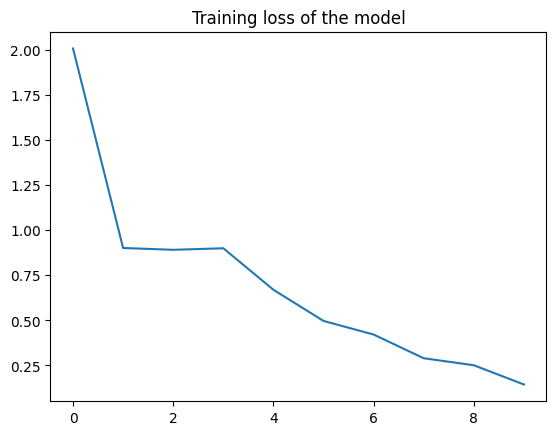

In [20]:
model  = Classifier(1024, [32,32, 10])
model.fit(X_train, y_train, optimizer = 'mini_batch' , iters = 10, batch_size = 1, learning_rate = 0.00042)

In [22]:
model.save_model("SGD_Model_EPOCH_3")

In [155]:
pr = model.predict(X_test)

[[7.36868033e-04 4.18117970e-03 6.33534730e-01 ... 4.66523451e-04
  1.54580965e-02 2.24047830e-03]
 [9.80783869e-01 4.05217344e-03 2.21596021e-04 ... 8.31021422e-03
  3.00986820e-04 5.67636947e-03]
 [8.33569199e-05 9.88594215e-01 1.11025203e-05 ... 4.14226010e-06
  2.16226292e-07 9.90393928e-03]
 ...
 [9.35646806e-01 2.59401208e-02 1.94793838e-02 ... 8.57479947e-03
  6.57998996e-04 3.54610191e-03]
 [2.91920494e-04 2.90814144e-05 7.76911978e-04 ... 7.36604991e-03
  3.53894386e-04 3.68095256e-06]
 [6.92804027e-05 1.42295240e-03 7.19843204e-04 ... 1.94966075e-04
  2.14814808e-04 1.82531917e-04]]


In [156]:
y_test

20569    2
6186     0
11417    1
7064     0
59855    7
        ..
21211    2
27344    3
7100     0
55159    6
52081    6
Name: label, Length: 17000, dtype: int64

# Check Accuracy


In [190]:
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix, ConfusionMatrixDisplay
acc = accuracy_score(y_test.values, pr)
rec = recall_score(y_test.values, pr, average='macro')


In [192]:
conf_mat = confusion_matrix(y_test.values, pr )
conf_mat

array([[1649,    0,    0,    0,    1,    0,    1,   11,    7,    5],
       [   2, 1682,    3,    2,    2,    3,    4,    0,    0,    5],
       [   0,    9, 1472,   85,    4,   24,   22,    2,    6,    3],
       [   0,    6,  103, 1575,    3,   25,   18,    4,    0,    2],
       [   0,    9,    1,    2, 1705,   18,    3,    4,   10,    8],
       [   0,    2,   27,   16,   26, 1590,    9,    5,    2,    1],
       [   7,   11,    5,   18,    9,    7, 1583,   28,    8,   18],
       [  24,    0,    2,    4,    2,   15,   27, 1661,    2,    0],
       [  11,    0,    2,    0,    2,    1,   14,    1, 1624,   11],
       [   2,   17,    2,    3,    5,    0,   13,    3,    7, 1673]])

In [193]:
rec

0.953639785345603